## Previsão de Séries Temporais do Custeio Administrativo do Governo Federal utilizando Redes Neurais LSTM

As séries temporais são conjuntos de dados organizados em ordem cronológica, onde cada observação está associada a um momento específico no tempo. Essa estrutura de dados é amplamente utilizada em diferentes áreas, como economia, finanças, meteorologia e muitas outras, devido à sua natureza sequencial e à capacidade de capturar padrões e tendências ao longo do tempo.

Gostaria de ter utilizado outros dados que são mais próximos do cotidiano, no entanto, muitos não posso divulgar por questões legais, então me baseei neste que está na base de dados abertos.

É importante salientar que há diversos outros fatores (econômicos, políticos, geopolíticos) que influenciam na previsão dessa despesa. Para mais detalhes sobre o Custeio Administrativo, é possível encontrar na Lei nº 4.320/1964, art. 12, § 1º, "Gastos com manutenção de serviços anteriormente criados, inclusive os destinados a atender a obras de conservação e adaptação de bens imóveis."
Basicamente são despesas públicas encontradas no rol de Despesas Correntes e não geram aumento de patrimônio para o Estado, apenas manutenção dos serviços já existentes.

Link dos dados: https://www.tesourotransparente.gov.br/visualizacao/series-temporais-do-tesouro-nacional

### 1) EDA (Exploratory Data Analysis) e ETL (Extract, Transform e Load)

### 1.1) Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.autograd import Variable

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler


from math import sqrt

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)

### 1.2) Carregamento do arquivo e Limpeza

In [2]:
df = pd.read_csv('./dados/Custeio_Administrativo.csv',sep=';')

In [3]:
df['Data'] = pd.to_datetime(df['Data'], format='%d/%m/%Y')

In [4]:
df = df.sort_values(by='Data', ascending=True)

In [5]:
df.set_index('Data', inplace=True)

In [6]:
df['Valor'] = df['Valor'].str.replace('.', '').str.replace(',', '.')
df['Valor'] = df['Valor'].astype(float)

In [7]:
df.tail()

,Valor
Data,
2023-01-01,2869.98
2023-02-01,3509.75
2023-03-01,5032.82
2023-04-01,4168.13
2023-05-01,5125.55


<AxesSubplot:xlabel='Data'>

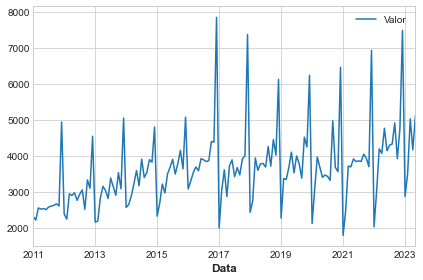

In [8]:
df.plot()

### 1.3) Função de uma das métricas que usarei para avaliar o modelo

O Erro Médio Absoluto em Percentual (MAPE):

$MAPE = \frac{1}{n} \sum_{i=1}^{n} \left|\frac{Atual - Previsto}{Atual}\right| \times 100$


In [9]:
def mape(atual, pred):
    mask = atual != 0
    atual_nonzero = atual[mask]
    pred_nonzero = pred[mask]
    return np.abs((atual_nonzero - pred_nonzero) / atual_nonzero).sum() / len(atual_nonzero) * 100

### 2) Construção do Modelo de Redes Neurais LSTM

### 2.1) Atribuição de variáveis e transformações para adaptar à arquitetura

In [10]:
prediction_window=12
n_input=12 
n_features=1 #previsão univariada, será usada para definir o tamanho do input

train = df.copy()

# normalização dos dados que o algoritmo espera receber
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)

### 2.2) Função para fazer a Rede Neural prever o 13º mês a partir das 12 amostras anteriores

In [11]:
def shaping(data, n_input):
    X_train=[]
    y_train=[]
    for i in range(n_input,len(data)):
        X_train.append(data[i-n_input:i])
        y_train.append(data[i])
    return np.array(X_train), np.array(y_train)

### 2.3) Ajuste dos tensores para o formato que o Pytorch espera receber

In [12]:
x, y = shaping(scaled_train, prediction_window)
train_size = int(len(train) - prediction_window*3)
val_size = len(train) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

X_train = Variable(torch.Tensor(np.array(x[:train_size])))
y_train = Variable(torch.Tensor(np.array(y[:train_size])))

X_valid = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
y_valid = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

### 2.4) Construção da arquitetura da Rede Neural LSTM

In [13]:
class LSTMnet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMnet, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # camada LSTM
        self.lstm = nn.LSTM(
            input_size=input_size, hidden_size=hidden_size,
            num_layers=num_layers, batch_first=True
        )
        
        # camada para saída da rede
        self.fc1 = nn.Linear(hidden_size,40)
        self.fc2 = nn.Linear(40,1)
        self.relu = nn.ReLU()
        
    # método de propagação forward pass da rede neural
    def forward(self,x):
        # inicialização dos estados ocultos
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        
        # propagação dos dados pela camada LSTM
        _, (h_out,_) = self.lstm(x, (h0,c0))
        
        # redicionamento da saída 
        h_out = h_out.view(-1, self.hidden_size)
        
        # camada de ativação ReLu -> f(x) = max (0, x)
        out = self.fc2(self.relu(self.fc1(h_out)))
        
        return out

### 2.5) Paramêtros

In [14]:
EPOCHS = 2000
LEARNING_RATE = 0.008
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

INPUT_SIZE = n_features
HIDDEN_SIZE = 100
NUM_LAYERS = 1

model = LSTMnet(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS)
model.to(DEVICE)
print(model)

LSTMnet(
  (lstm): LSTM(1, 100, batch_first=True)
  (fc1): Linear(in_features=100, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=1, bias=True)
  (relu): ReLU()
)


### 2.6) Definição da função de perda e do otimizador

In [15]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

### 2.7) Definição dos parâmetros para Early Stopping

In [16]:
early_stopping_patience = 500
early_stopping_counter = 0
valid_loss_min=np.inf

### 2.8) Treinamento do Modelo

In [17]:
for epoch in range(EPOCHS):
    optimizer.zero_grad()
    model.train()
    output = model(X_train)
    
    train_loss = criterion(output, y_train)
    
    train_loss.backward()
    optimizer.step()
    
    # validação em cada época para aplicar Early Stopping
    with torch.no_grad():
        model.eval()
        output_val = model(X_valid)
        valid_loss = criterion(output_val, y_valid)
        
        # salvando o modelo com a menor perda de validação
        if valid_loss <= valid_loss_min:
            torch.save(model.state_dict(), './model/lstm.pt')
#             print(f'Epoch {epoch + 0:01}: Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...')
            valid_loss_min = valid_loss
            early_stopping_counter=0 # reseta contador quando o loss cai
        else:
#             print(f'Epoch {epoch + 0:01}: Validation loss did not decrease')
            early_stopping_counter+=1

        # aplicando Early Stopping caso a perda de validação não diminua por um número de epochs que defini
        if early_stopping_counter > early_stopping_patience:
            print('Early stopped at epoch :', epoch)
            break

#         print(f'\t Train_Loss: {train_loss:.4f} Val_Loss: {valid_loss:.4f}  BEST VAL Loss: {valid_loss_min:.4f}\n')

Early stopped at epoch : 678


### 3) Previsão do Treino x Teste
Previsão utilizando dados de treino e teste para avaliar as métricas e fazer os devidos comparativos

In [18]:
# carregando o modelo treinado para fazer previsão
model.load_state_dict(torch.load('./model/lstm.pt'))

valid_predict = model(X_valid)
y_pred_scaled = valid_predict.data.numpy()
y_pred = scaler.inverse_transform(y_pred_scaled)

df_pred=train.iloc[-24:]
df_pred['prediction']=y_pred

C:\Users\ariel\AppData\Local\Temp\ipykernel_4196\4007267415.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['prediction']=y_pred


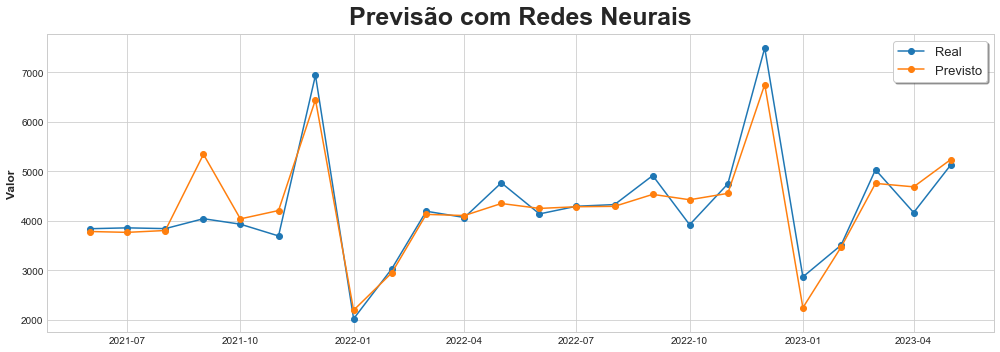

In [19]:
plt.figure(figsize=(14,5))
plt.plot(df_pred["Valor"], label="Real", marker="o")
plt.plot(df_pred["prediction"], label="Previsto", marker="o")
plt.title("Previsão com Redes Neurais", fontsize=25)
plt.ylabel("Valor")
plt.legend(title_fontsize=14, fontsize=13, fancybox=True, shadow=True, frameon=True)
fig = plt.gcf()
plt.show()
fig.savefig('./graficos/RedesNeurais.png', format='png')

### 4) Avaliação da Previsão
<p>Mape: quanto mais baixo melhor</p>
<p>R²: quanto mais próximo de 1 (100%) melhor</p>

In [20]:
mape_lstm = mape(df_pred["Valor"], df_pred["prediction"])
print(f"MAPE OF LSTM MODEL : {mape_lstm:.2f} %")

MAPE OF LSTM MODEL : 6.85 %


In [21]:
print(f'{r2_score(df_pred["Valor"], df_pred["prediction"]):.4f}%')

0.8609%


### 5) Previsão para um novo período de 12 meses

### 5.1) Previsão sequencial da série

In [22]:
test_predictions = [] # lista para armazenar as previsões

# avalia batch de previsão daqueles 12 meses instanciados no início do notebook
eval_batch = Variable(torch.Tensor(scaled_train[-n_input:]))

# reshape dos dados (1,12,1)
current_batch=eval_batch.reshape((1,n_input,n_features))
for i in range(len(scaled_train[-n_input:])):
    # previsão do batch atual
    current_pred = model(current_batch)
    
    # junta as previsões à lista
    test_predictions.append(current_pred)
    
    # atualiza o batch de avaliação usando a previsão removendo o primeiro valor   
    # faz a função do "sliding window" para fazer previsão de forma sequencial na time series
    current_batch = torch.cat((current_batch[:,1:,:],current_pred.reshape(1,1,1)),1)

### 5.2) Formata as previsões para obter valores finais

In [23]:
forec_vals = [val.flatten().item() for val in test_predictions]
forec_vals = np.array(forec_vals).reshape(-1,1)
forec_vals = scaler.inverse_transform(forec_vals)

In [24]:
date_offset=12
forecast_dates =  (train.index + pd.DateOffset(months=date_offset))[-date_offset:]
forecast_dates

DatetimeIndex(['2023-06-01', '2023-07-01', '2023-08-01', '2023-09-01',
               '2023-10-01', '2023-11-01', '2023-12-01', '2024-01-01',
               '2024-02-01', '2024-03-01', '2024-04-01', '2024-05-01'],
              dtype='datetime64[ns]', name='Data', freq=None)

In [25]:
df_forecast=pd.DataFrame({'date': forecast_dates})
df_forecast.set_index('date', inplace=True)
df_forecast['prediction'] = forec_vals
df_forecast.head(12)

,prediction
date,
2023-06-01,4715.412964
2023-07-01,4880.108572
2023-08-01,4952.617748
2023-09-01,5337.228141
2023-10-01,4614.367731
2023-11-01,5550.308902
2023-12-01,6933.635020
2024-01-01,3057.375240
2024-02-01,4127.120718


In [26]:
df_full= pd.concat([df_pred, df_forecast])

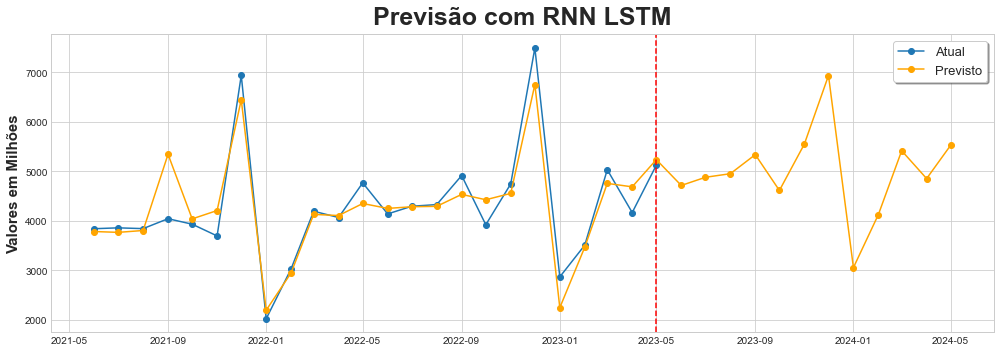

In [27]:
plt.figure(figsize=(14,5))
plt.plot(df_full["Valor"], label="Atual", marker="o")
plt.plot(df_full["prediction"], label="Previsto", marker="o", color="orange")
plt.axvline(df_pred.index[-1], color="red", linestyle="--")
plt.title("Previsão com RNN LSTM", fontsize=25)
plt.ylabel('Valores em Milhões', fontsize=15)
plt.legend(title_fontsize=14, fontsize=13, fancybox=True, shadow=True, frameon=True)
fig = plt.gcf()
plt.show()
fig.savefig('./graficos/RedesNeuraisPrevisao.png', format='png')

### 6) Considerações Finais:

Após a implementação do modelo de previsão e a realização de avaliações cuidadosas, foram obtidos resultados promissores na capacidade de prever a série temporal com base nos dados coletados. A qualidade do modelo foi avaliada por meio de análises quantitativas e, quando relevante, também foram considerados aspectos qualitativos para garantir a relevância e a utilidade das previsões geradas.

Os resultados obtidos fornecem uma base sólida para a aplicação prática das previsões em cenários reais, auxiliando a tomada de decisões informadas e estratégicas em relação aos dados temporais analisados. No entanto, é importante ressaltar que a precisão do modelo pode ser afetada por mudanças nas tendências e comportamentos futuros, portanto, o monitoramento contínuo e a atualização do modelo com novos dados são aspectos relevantes para sua aplicação a longo prazo.